In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from keras.models import load_model
from skimage.transform import resize
from cv2 import imread
from glob import glob
from tqdm import tqdm

In [2]:
path='D:/Project/gan_repo/test.h5'
# Function to read and normalize images
def imread_and_normalize(im_path):
    OUT_DIM = (128, 128)
    img_data = np.mean(imread(im_path), 2).astype(np.uint8)
    n_img = (255 * resize(img_data, OUT_DIM, mode='constant')).clip(0, 255).astype(np.uint8)
    return np.expand_dims(n_img, -1)

In [3]:
def find_last_model_checkpoint():
    last_model_point=0
    for f in (glob('generated_models/Generator_model_*')):
        file = f.split('/')[-1]
        checkpoint_no = int(file.split('_')[-1])
        if checkpoint_no > last_model_point:
            last_model_point = checkpoint_no

    return int(last_model_point)

In [7]:
# Load generator model
generator = load_model('generated_models/Generator_model_{}'.format(find_last_model_checkpoint()))

# Generate 1000 images from generator
generated_images = []
for _ in range(1000):
    noise = np.random.normal(0, 1, (1, 100))
    generated_img = generator.predict(noise)
    generated_img = 0.5 * generated_img + 0.5
    generated_images.append(generated_img)

# Import classification model weights from HDF5 file
classification_model = load_model('classification_model/xray_model_real.keras')

1/1 [==============================] - 0s 52ms/step


In [9]:
# Test the generated images to assign labels
# Assuming sampled_df contains paths to real images and labels
# Assigning labels using the classification model is a placeholder
labels = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion','Emphysema','Fibrosis',
 'Hernia','Infiltration','Mass','Nodule','Pleural_Thickening','Pneumonia','Pneumothorax']

generated_labels = []
for img in generated_images:
    img_resized = resize(img.squeeze(), (96, 96))
    img_resized = np.expand_dims(img_resized, axis=-1)
    img_resized = np.expand_dims(img_resized, axis=0)
    label = classification_model.predict(img_resized)  # Predict label using classification model
    generated_labels.append(label)

1/1 [==============================] - 0s 28ms/step


In [10]:
# Save the generated images and labels as an HDF5 file
with h5py.File(path, 'w') as h5_file:
    for i, (img, label) in tqdm(enumerate(zip(generated_images, generated_labels))):
        h5_file.create_dataset('image_' + str(i), data=img)
        h5_file.create_dataset('label_' + str(i), data=label)

0it [00:00, ?it/s]

1000it [00:00, 2936.54it/s]


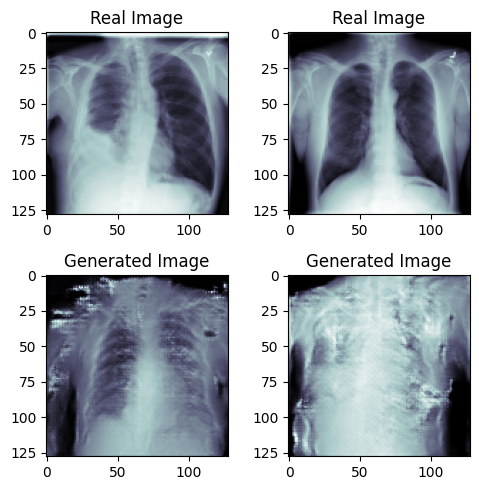

In [13]:
# Load images dataset from the provided h5_path
h5_path = 'chest_xray.h5'
with h5py.File(h5_path, 'r') as h5_data:
    img_ds = h5_data['images'][:]

# Visualize two generated and two real images
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
for i in range(2):
    # Real image
    real_image = img_ds[i, :, :, 0]
    axes[0, i].imshow(real_image, cmap='bone')
    axes[0, i].set_title('Real Image')
    
    # Generated image generated_images[i][0, :, :, 0] img_ds[i+4, :, :, 0]
    generated_image = generated_images[i+4][0, :, :, 0]
    axes[1, i].imshow(generated_image, cmap='bone')
    axes[1, i].set_title('Generated Image')

plt.tight_layout()
plt.show()